# Feature Tracking

In [1]:
import cv2
import numpy as np

def start_tracking(path, max_iter,feat_num): #Inputs are video path, max iter for frames, and num of points to track
    # Capture the input frame
    cap = cv2.VideoCapture(path)

    # Downsampling factor for the image 
    scaling_factor = 0.5

    # Number of frames to keep in the buffer when you
    # are tracking. If you increase this number,
    # feature points will have more "inertia"
    num_frames_to_track = 5

    # Skip every 'n' frames. This is just to increase the speed.
    num_frames_jump = 2

    tracking_paths = []
    tracking_paths_store=[]
    frame_index = 0

    # 'winSize' refers to the size of each patch. These patches
    # are the smallest blocks on which we operate and track
    # the feature points. You can read more about the parameters
    # here: http://goo.gl/ulwqLk
    tracking_params = dict(winSize  = (11, 11), maxLevel = 2,
            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Iterate until the user presses the ESC key
    iter=0
    while True:
        # read the input frame
        ret, frame = cap.read()

        # downsample the input frame
        frame = cv2.resize(frame, None, fx=scaling_factor,
                fy=scaling_factor, interpolation=cv2.INTER_AREA)

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        output_img = frame.copy()

        if len(tracking_paths) > 0:
            prev_img, current_img = prev_gray, frame_gray
            feature_points_0 = np.float32([tp[-1] for tp in tracking_paths]).reshape(-1, 1, 2)

            # Compute feature points using optical flow. You can
            # refer to the documentation to learn more about the
            # parameters here: http://goo.gl/t6P4SE
            feature_points_1, _, _ = cv2.calcOpticalFlowPyrLK(prev_img, current_img, feature_points_0,
                    None, **tracking_params)
            feature_points_0_rev, _, _ = cv2.calcOpticalFlowPyrLK(current_img, prev_img, feature_points_1,
                    None, **tracking_params)

            # Compute the difference of the feature points
            diff_feature_points = abs(feature_points_0- feature_points_0_rev).reshape(-1, 2).max(-1)

            # threshold and keep the good points
            good_points = diff_feature_points < 1

            new_tracking_paths = []
            
            for tp, (x, y), good_points_flag in zip(tracking_paths,
                        feature_points_1.reshape(-1, 2), good_points):
                if not good_points_flag:
                    continue

                tp.append((x, y))
                
                # Using the queue structure i.e. first in,
                # first out
                if len(tp) > num_frames_to_track:
                    del tp[0]

                new_tracking_paths.append(tp)

                # draw green circles on top of the output image
                cv2.circle(output_img, (int(x), int(y)), 3, (0, 255, 0), -1)

            tracking_paths = new_tracking_paths
            tracking_paths_store.append(tracking_paths[0:feat_num])
            # draw green lines on top of the output image
            cv2.polylines(output_img, [np.int32(tp) for tp in tracking_paths], False, (0, 150, 0))

        # 'if' condition to skip every 'n'th frame
        if not frame_index % num_frames_jump:
            mask = np.zeros_like(frame_gray)
            mask[:] = 255
            for x, y in [np.int32(tp[-1]) for tp in tracking_paths]:
                cv2.circle(mask, (x, y), 6, 0, -1)

            # Extract good features to track. You can learn more
            # about the parameters here: http://goo.gl/BI2Kml
            feature_points = cv2.goodFeaturesToTrack(frame_gray,
                    mask = mask, maxCorners = 500, qualityLevel = 0.3,
                    minDistance = 7, blockSize = 7)

            if feature_points is not None:
                for x, y in np.float32(feature_points).reshape (-1, 2):
                    tracking_paths.append([(x, y)])
                tracking_paths_store.append(tracking_paths[0:feat_num])
        frame_index += 1
        iter+=1
        prev_gray = frame_gray

        cv2.imshow('Optical Flow', output_img)

        # Check if the user pressed the ESC key
        c = cv2.waitKey(1)
        if c == 27:
            break
        if iter ==max_iter:
            break
    return np.array(tracking_paths_store)

In [2]:
#Medusa Observation Matrix
obs_matrix_medusa=start_tracking("/Users/michaelzakariaie/Desktop/Machine Perception/Project 2/medusa.dv",350,108)
print(obs_matrix_medusa.shape)
cv2.destroyAllWindows()

(524, 108, 5, 2)


In [3]:
#Castle Observation Matrix
obs_matrix_castle=start_tracking("/Users/michaelzakariaie/Desktop/Machine Perception/Project 2/My_video.mp4",1500,230)
print(obs_matrix_castle.shape)
cv2.destroyAllWindows()

(1780,)


/var/folders/j6/hz3f_4r91zbb_52fgf88bm940000gn/T/ipykernel_4441/3558313455.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(tracking_paths_store)


In [4]:
print(len(obs_matrix_medusa[100]))
print(len(obs_matrix_castle[100]))
print(len(obs_matrix_medusa[100][0]))
print(len(obs_matrix_castle[100][0]))
print(len(obs_matrix_medusa[100][0][0]))
print(len(obs_matrix_castle[100][0][0]))

108
230
5
5
2
2


# Applying Tomasi Kanade Factorization 

In [5]:
#Getting observation matrices in right form for factorization

#Medusa
w_medusa=np.zeros((2*524,108*5))
ind=0
for i in range(524):
    x_list=np.zeros(108*5)
    y_list=np.zeros(108*5)
    list=obs_matrix_medusa[i] #Extract 108 lengthed list
    index=0
    for j in range(len(list)): #108
        list_1=list[j]
        for k in range(5):
            list_2=list_1[k]
            x=list_2[0]
            y=list_2[1]
            x_list[index]=x
            y_list[index]=y
            index+=1
    w_medusa[ind,:]=x_list
    w_medusa[ind+1,:]=y_list
    ind+=2
print("Observation Matrix Shape for Medusa:",w_medusa.shape)

#Castle
w_castle=np.zeros((2*1780,230*5))
ind=0
for i in range(1780):
    x_list=np.zeros(230*5)
    y_list=np.zeros(230*5)
    list=obs_matrix_castle[i] #Extract 230 lengthed list
    index=0
    for j in range(len(list)): #230
        list_1=list[j]
        for k in range(5):
            list_2=list_1[k]
            x=list_2[0]
            y=list_2[1]
            x_list[index]=x
            y_list[index]=y
            index+=1
    w_castle[ind,:]=x_list
    w_castle[ind+1,:]=y_list
    ind+=2
print("Observation Matrix Shape for Castle:",w_castle.shape)

Observation Matrix Shape for Medusa: (1048, 540)
Observation Matrix Shape for Castle: (3560, 1150)


In [6]:
display(w_medusa)

array([[252.50611877, 249.87469482, 249.87469482, ..., 236.44555664,
        233.55915833, 233.55915833],
       [124.17193604, 124.69539642, 124.69539642, ...,  89.87973785,
         90.60215759,  90.60215759],
       [252.50611877, 249.87469482, 249.87469482, ..., 236.44555664,
        233.55915833, 233.55915833],
       ...,
       [124.17193604, 124.69539642, 124.69539642, ..., 107.78907776,
        108.65110779, 108.65110779],
       [252.50611877, 249.87469482, 249.87469482, ..., 250.17608643,
        246.78327942, 246.78327942],
       [124.17193604, 124.69539642, 124.69539642, ..., 107.78907776,
        108.65110779, 108.65110779]])

In [7]:
#Printing some observation
print("Number of Frames for Medusa:",w_medusa.shape[0]/2)
print("Number of Feature Points Tracked for Medusa:",w_medusa.shape[1])
print("Number of Frames for Castle:",w_castle.shape[0]/2)
print("Number of Feature Points Tracked for Castle:",w_castle.shape[1])

Number of Frames for Medusa: 524.0
Number of Feature Points Tracked for Medusa: 540
Number of Frames for Castle: 1780.0
Number of Feature Points Tracked for Castle: 1150


In [8]:
#SVD Decomposition 
def svd(matrix):
    u, s, vh = np.linalg.svd(matrix, full_matrices=True)
    u_new=u[:,0:3]
    v_new=vh[0:3,:]
    s_new=np.diag(s[0:3])
    print("U ",u_new.shape)
    print("V ",v_new.shape)
    print("Sigma ",s_new.shape)
    return u_new,s_new,v_new
u_med,s_med,v_med=svd(w_medusa)
u_cas,s_cas,v_cas=svd(w_castle)


U  (1048, 3)
V  (3, 540)
Sigma  (3, 3)
U  (3560, 3)
V  (3, 1150)
Sigma  (3, 3)


In [9]:
print(s_med)

[[142780.90145806      0.              0.        ]
 [     0.          20443.72828236      0.        ]
 [     0.              0.          18366.04814021]]


In [49]:
# Extract Q matrix using orthonormality constraint and Newton's method
from sklearn.preprocessing import normalize
#For 3 frames only extract if and jf
i_f_med=np.matmul(u_med,np.sqrt(s_med))[0:3,:]
j_f_med=np.matmul(u_med,np.sqrt(s_med))[524:524+3,:]
i_f_cas=np.matmul(u_cas,np.sqrt(s_cas))[0:3,:]
j_f_cas=np.matmul(u_cas,np.sqrt(s_cas))[1780:1780+3,:]

#Normalize Vectors
i_f_med = normalize(i_f_med)
j_f_med = normalize(j_f_med)
i_f_cas = normalize(i_f_cas)
j_f_cas = normalize(j_f_cas)

#Define Newton's Method Functions

def function(Q):

    return [(i.T @ Q @ Q.T @ i)-1 ,(j.T @ Q @ Q.T @ j)-1 , (i.T @ Q @ Q.T @ j)]

def jacobian(Q):

    return [[i@i.T@Q+i@i.T@Q],[j@j.T@Q+j@j.T@Q],[i@j.T@Q+j@i.T@Q]]

def newton(X,function,jacobian,max = 50,tol = 1e-3):
    for i in range(int(max)):
        print("On Iteration:",i)
        J = jacobian(X) # find jacobian 
        Y = np.array(function(X)) # 
        #J=np.real(J)
        #Y=np.real(Y)
        #Y=Y.reshape(3,1)
        print('J:')
        print(J)
        print(np.asarray(J).shape)
        print('Y:')
        print(Y)
        print(np.asarray(Y).shape)
        dX=np.linalg.pinv(J)@Y
        dX=dX.reshape(9,9)
        X=X.astype(float)
        X -= dX # step X by dX 
        if np.linalg.norm(dX)<tol: #Convergence criteria
            break
    return X

In [51]:
i=i_f_med
j=j_f_med
Q_0=np.random.random(size=(3,3))
print(Q_0)
newton(Q_0,function,jacobian)

Camera Motion Matrix Shape for Medusa: (1048, 3)
Scene Structure Matrix Shape for Medusa: (3, 540)
Camera Motion Matrix Shape for Castle: (3560, 3)
Scene Structure Matrix Shape for Castle: (3, 1150)


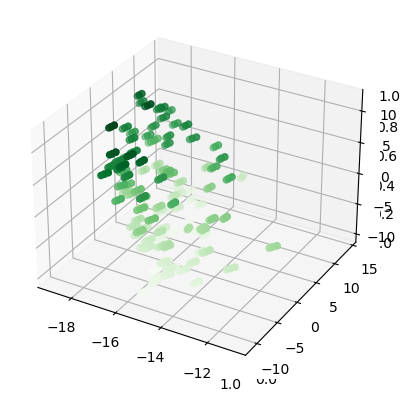

In [66]:
# Find M(camera motion/rotation) and S (Scene Structure) matrices
M_med=np.matmul(u_med,np.sqrt(s_med))
S_med=np.matmul(np.sqrt(s_med),v_med)
M_cas=np.matmul(u_cas,np.sqrt(s_cas))
S_cas=np.matmul(np.sqrt(s_cas),v_cas)

print("Camera Motion Matrix Shape for Medusa:",M_med.shape)
print("Scene Structure Matrix Shape for Medusa:",S_med.shape)
print("Camera Motion Matrix Shape for Castle:",M_cas.shape)
print("Scene Structure Matrix Shape for Castle:",S_cas.shape)

#Plot Medusa Scene Structure Matrix
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = S_med[2,:]
xdata = S_med[0,:]
ydata = S_med[1,:]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

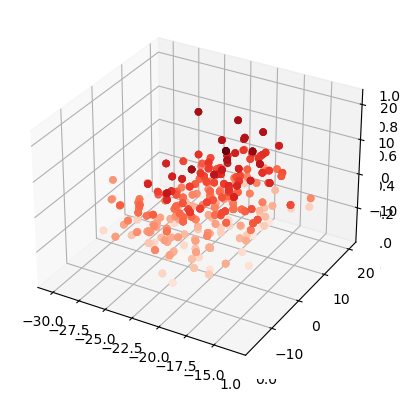

In [58]:
#Plot Castle Scene Structure Matrix
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = S_cas[2,:]
xdata = S_cas[0,:]
ydata = S_cas[1,:]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');

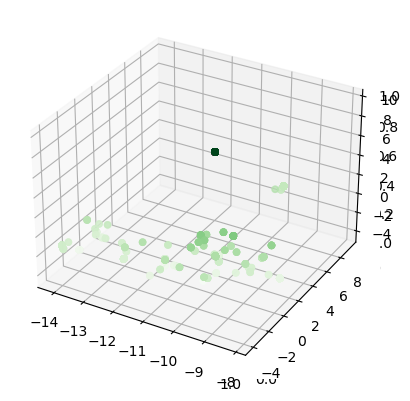

In [59]:
#Plot Medusa Camera Motion Matrix
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = M_med[:,2]
xdata = M_med[:,0]
ydata = M_med[:,1]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

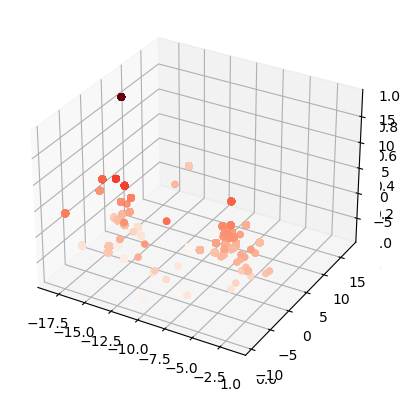

In [60]:
#Plot Castle Camera Motion Matrix
fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = M_cas[:,2]
xdata = M_cas[:,0]
ydata = M_cas[:,1]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');